In [1]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection  import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import xgboost as xgb

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

from textblob import TextBlob, Word, Blobber
from IPython.core import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from tqdm import tqdm
from bs4 import BeautifulSoup
import warnings
import copy

warnings.filterwarnings('ignore')
stop_words = stopwords.words('english')
pd.options.display.max_columns = 30
%matplotlib inline

In [2]:
%ls ../input/project/project/project/data_reviews/

submission.csv  x_train.csv  yproba1_test.txt     yproba1_test_part1.txt
x_test.csv      y_train.csv  yproba1_test_df.txt


In [3]:
import os
os.getcwd()
#os.chdir('/Users/temp/Downloads/project/project/data_reviews')  
#os.chdir('project/project/data_reviews')  
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])


In [4]:
%ls

__notebook__.ipynb  __output__.json


In [5]:
x_test = pd.read_csv('../input/project/project/project/data_reviews/x_test.csv')
x_train = pd.read_csv('../input/project/project/project/data_reviews/x_train.csv')

In [6]:
y_train = pd.read_csv('../input/project/project/project/data_reviews/y_train.csv')
y_train.head()

,is_positive_sentiment
0,0
1,0
2,0
3,0
4,0


In [7]:
###LOWER CASE############
x_train["text"] = (x_train["text"].apply(lambda x: " ".join(x.lower() for x in x.split())))
x_test["text"] = (x_test["text"].apply(lambda x: " ".join(x.lower() for x in x.split())))
x_train.head()

,website_name,text
0,amazon,oh and i forgot to also mention the weird colo...
1,amazon,that one didn't work either.
2,amazon,waste of 13 bucks.
3,amazon,"product is useless, since it does not have eno..."
4,amazon,none of the three sizes they sent with the hea...


In [8]:
# Removing punctuation
x_train["text"] = x_train["text"].str.replace('[^\w\s]','')
x_test["text"] = x_test["text"].str.replace('[^\w\s]','')
x_train.head()

,website_name,text
0,amazon,oh and i forgot to also mention the weird colo...
1,amazon,that one didnt work either
2,amazon,waste of 13 bucks
3,amazon,product is useless since it does not have enou...
4,amazon,none of the three sizes they sent with the hea...


In [9]:
####lEMENTIZATIOO#############
x_train["text"]  = (x_train["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])))
x_test["text"]  = (x_test["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])))
x_train.head()

,website_name,text
0,amazon,oh and i forgot to also mention the weird colo...
1,amazon,that one didnt work either
2,amazon,waste of 13 buck
3,amazon,product is useless since it doe not have enoug...
4,amazon,none of the three size they sent with the head...


In [10]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    Log loss, aka logistic loss or cross-entropy loss.
    This is the loss function used in (multinomial) logistic regression and 
    extensions of it such as neural networks, defined as the negative log-likelihood of the true labels 
    given a probabilistic classifier’s predictions. The log loss is only defined for two or more labels.
    Accuracy is the count of predictions where your predicted value equals the actual value. 
    Accuracy is not always a good indicator because of its yes or no nature.
    Log Loss takes into account the uncertainty of your prediction based on how much it varies from the actual label. 
    This gives us a more nuanced view into the performance of our model.
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [11]:
x_train = x_train['text']
x_test = x_test['text']
y_train = y_train['is_positive_sentiment']
xtrain1, xvalid, ytrain1, yvalid = train_test_split(x_train, y_train 
                                                  , stratify=y_train
                                                  ,random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [12]:
######tfidf vector Creation##############
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain1) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain1) 
xvalid_tfv = tfv.transform(xvalid)
xtrain_tfv.shape,xvalid_tfv.shape

((2160, 1186), (240, 1186))

In [13]:
######Count vector Creation##############
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain1) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain1) 
xvalid_ctv = ctv.transform(xvalid)

In [14]:
# Fitting a simple Logistic Regression on TFIDF#########
def grid_search_best_params(model_name, pipeline, params, xtrain, ytrain, xvalid, yvalid, X, Y):
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1,refit='accuracy', scoring=['accuracy','neg_log_loss','roc_auc'])
    grid.fit(X, Y)
    predictions = grid.predict_proba(xvalid)
    grids[model_name] = copy.deepcopy(grid)
    #print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
    y_pred_test = grid.predict(xvalid)
    y_test_proba = grid.predict_proba(xvalid)
    vec_type = 'TF-IDF Vectorizer' if 'TF-IDF' in model_name else 'CountVectorizer'
    print("Log Loss for %s on Test %s : %s"%(model_name,vec_type,log_loss(yvalid, y_pred_test)))
    print("ROC AUC for %s on Test %s : %s"%(model_name,vec_type,roc_auc_score(yvalid, y_test_proba.T[1])))
    print("Accuracy for %s on Test %s : %s"%(model_name,vec_type,accuracy_score(yvalid, y_pred_test)))
    y_pred_train=grid.predict(xtrain)
    y_train_proba = grid.predict_proba(xtrain)
    print("Log Loss for %s on Training %s : %s"%(model_name,vec_type,log_loss(ytrain, y_pred_train)))
    print("ROC AUC for %s on Training %s : %s"%(model_name,vec_type,roc_auc_score(ytrain, y_train_proba.T[1])))
    print("Accuracy for %s on Training %s : %s"%(model_name, vec_type,accuracy_score(ytrain,y_pred_train)))
    print('Best Score : %.2f'%(grid.best_score_*100))
    print('Best Paramerter Settings : ',grid.best_params_)
    #print("ROC Area Under Curve in % : ",cross_val_score(pipeline_lr, X, Y, scoring="roc_auc", cv=5)*100)
    conf_mat = confusion_matrix(yvalid, y_pred_test)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    accuracies = {'Train Accuracy':accuracy_score(ytrain,y_pred_train), 
                  'Test Accuracy':accuracy_score(yvalid, y_pred_test),
                  'Best Accuracy': grid.best_score_,
                  'Train Log Loss':log_loss(ytrain, y_pred_train), 
                  'Test Log Loss':log_loss(yvalid, y_pred_test),
                  'Train ROC AUC': roc_auc_score(ytrain, y_train_proba.T[1]), 
                  'Test ROC AUC': roc_auc_score(yvalid, y_test_proba.T[1]),
                  'Best Param Settings' :grid.best_params_}
    return accuracies

In [15]:
grids = {}
accuracies = {}

Log Loss for LogisticRegresion(TF-IDF) on Test TF-IDF Vectorizer : 3.4539076243947013
ROC AUC for LogisticRegresion(TF-IDF) on Test TF-IDF Vectorizer : 0.9544097222222223
Accuracy for LogisticRegresion(TF-IDF) on Test TF-IDF Vectorizer : 0.9
Log Loss for LogisticRegresion(TF-IDF) on Training TF-IDF Vectorizer : 3.613813809171678
ROC AUC for LogisticRegresion(TF-IDF) on Training TF-IDF Vectorizer : 0.9523932613168724
Accuracy for LogisticRegresion(TF-IDF) on Training TF-IDF Vectorizer : 0.8953703703703704
Best Score : 77.62
Best Paramerter Settings :  {'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 1)}


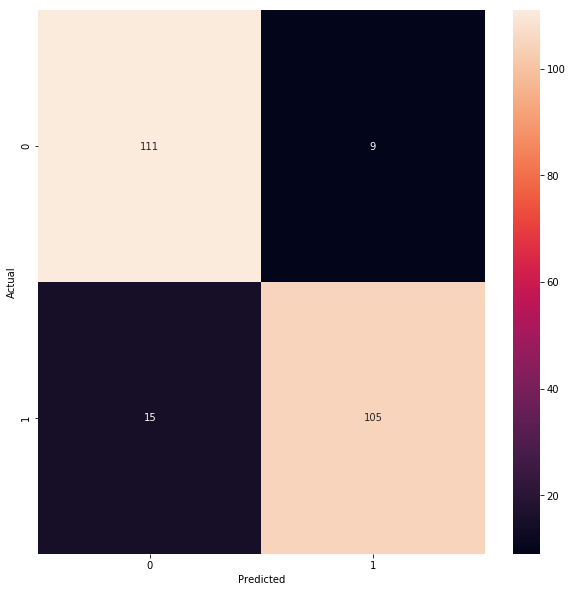

In [16]:
    # Fitting a simple Logistic Regression on TFIDF#########
params_lr = {'logisticregression__C': [0.1, 0.5, 1, 10],
             'logisticregression__penalty': ['l1','l2'],
          "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3), (2,3), (3,3)]}
pipeline_lr = make_pipeline(TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english'), LogisticRegression())

accuracies['LogisticRegresion(TF-IDF)'] = grid_search_best_params('LogisticRegresion(TF-IDF)',pipeline_lr, params_lr,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

Log Loss for LogisticRegresion(CV) on Test CountVectorizer : 1.295220773088947
ROC AUC for LogisticRegresion(CV) on Test CountVectorizer : 0.9897222222222223
Accuracy for LogisticRegresion(CV) on Test CountVectorizer : 0.9625
Log Loss for LogisticRegresion(CV) on Training CountVectorizer : 1.3271981601307896
ROC AUC for LogisticRegresion(CV) on Training CountVectorizer : 0.9891499485596708
Accuracy for LogisticRegresion(CV) on Training CountVectorizer : 0.961574074074074
Best Score : 79.12
Best Paramerter Settings :  {'countvectorizer__ngram_range': (1, 1), 'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}


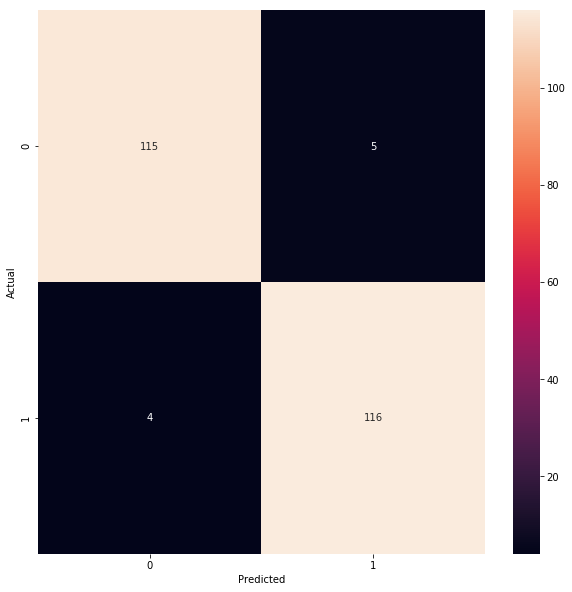

In [17]:
# Fitting a simple Logistic Regression on TFIDF#########
params_lr = {'logisticregression__C': [0.1, 0.5, 1, 10],
             'logisticregression__penalty': ['l1','l2'],
          "countvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3), (2,3), (3,3)]}
pipeline_lr = make_pipeline(CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            stop_words = 'english'), LogisticRegression())

accuracies['LogisticRegresion(CV)'] = grid_search_best_params('LogisticRegresion(CV)',pipeline_lr, params_lr,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

In [18]:
# Fitting a simple SVC on TFIDF#########
params_svc = {#'svc__kernel': ['rbf','poly','sigmoid'],
                'svc__C': [.1, 1, 10, 100, 10/xtrain_tfv.shape[1]],
                'svc__gamma' : [1/xtrain_tfv.shape[1],'auto','scale'],
                "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3,3)]}
pipeline_svc = make_pipeline(TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english'), SVC(probability=True))

#accuracies['SVC(TF-IDF)'] = grid_search_best_params('SVC(TF-IDF)',pipeline_svc, params_svc,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

In [19]:
# Fitting a simple SVC on TFIDF#########
params_svc = {#'svc__kernel': ['rbf','poly','sigmoid'],
                'svc__C': [.1, 1, 10, 100, 10/xtrain_tfv.shape[1]],
                'svc__gamma' : [1/xtrain_tfv.shape[1],'auto','scale'],
                "countvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3,3)]}
pipeline_svc = make_pipeline(CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            stop_words = 'english'), SVC(probability=True))

#accuracies['SVC(CV)'] = grid_search_best_params('SVC(CV)',pipeline_svc, params_svc,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

Log Loss for NaiveBayes(TF-IDF) on Test TF-IDF Vectorizer : 3.5978291876747064
ROC AUC for NaiveBayes(TF-IDF) on Test TF-IDF Vectorizer : 0.9649652777777779
Accuracy for NaiveBayes(TF-IDF) on Test TF-IDF Vectorizer : 0.8958333333333334
Log Loss for NaiveBayes(TF-IDF) on Training TF-IDF Vectorizer : 3.7097648496809734
ROC AUC for NaiveBayes(TF-IDF) on Training TF-IDF Vectorizer : 0.9582926097393689
Accuracy for NaiveBayes(TF-IDF) on Training TF-IDF Vectorizer : 0.8925925925925926
Best Score : 76.58
Best Paramerter Settings :  {'multinomialnb__alpha': 1.0, 'tfidfvectorizer__ngram_range': (1, 2)}


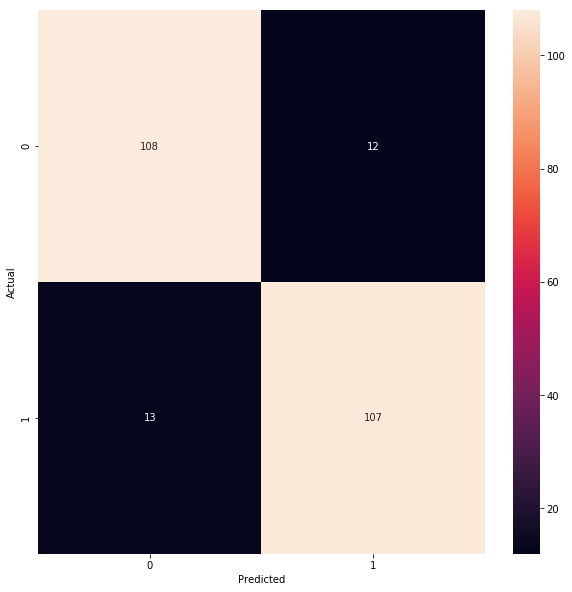

In [20]:
# Fitting a simple Naive Bayes on TFIDF#########
params_nb = {'multinomialnb__alpha': [0.1, .5, 1.0 , 10],
                "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)]}
pipeline_nb = make_pipeline(TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english'), MultinomialNB())

accuracies['NaiveBayes(TF-IDF)'] = grid_search_best_params('NaiveBayes(TF-IDF)',pipeline_nb, params_nb,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

Log Loss for NaiveBayes(CV) on Test CountVectorizer : 1.0073943048087324
ROC AUC for NaiveBayes(CV) on Test CountVectorizer : 0.9970138888888889
Accuracy for NaiveBayes(CV) on Test CountVectorizer : 0.9708333333333333
Log Loss for NaiveBayes(CV) on Training CountVectorizer : 0.5916431108173337
ROC AUC for NaiveBayes(CV) on Training CountVectorizer : 0.9985639574759946
Accuracy for NaiveBayes(CV) on Training CountVectorizer : 0.9828703703703704
Best Score : 79.71
Best Paramerter Settings :  {'countvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 1.0}


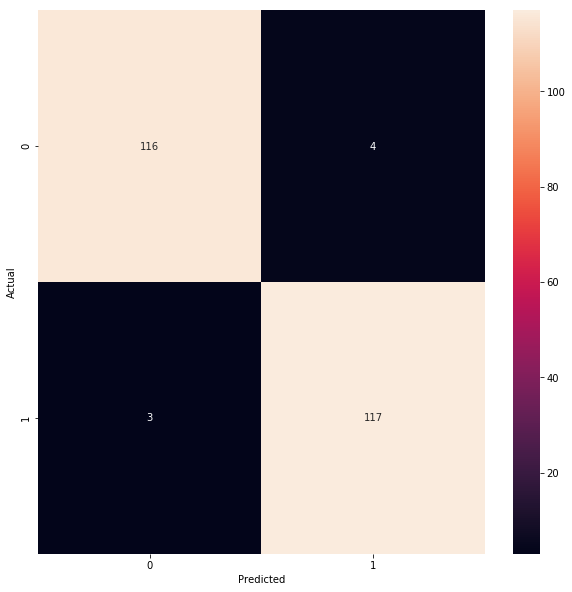

In [21]:
# Fitting a simple Naive Bayes on TFIDF#########
params_nb = {'multinomialnb__alpha': [0.1, .5, 1.0 , 10],
                "countvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)]}
pipeline_nb = make_pipeline(CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            stop_words = 'english'), MultinomialNB())

accuracies['NaiveBayes(CV)'] = grid_search_best_params('NaiveBayes(CV)',pipeline_nb, params_nb,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

Log Loss for RandomForest(TF-IDF) on Test TF-IDF Vectorizer : 0.8634760731846863
ROC AUC for RandomForest(TF-IDF) on Test TF-IDF Vectorizer : 0.9981597222222223
Accuracy for RandomForest(TF-IDF) on Test TF-IDF Vectorizer : 0.975
Log Loss for RandomForest(TF-IDF) on Training TF-IDF Vectorizer : 0.3997565775265511
ROC AUC for RandomForest(TF-IDF) on Training TF-IDF Vectorizer : 0.9993925754458162
Accuracy for RandomForest(TF-IDF) on Training TF-IDF Vectorizer : 0.9884259259259259
Best Score : 76.33
Best Paramerter Settings :  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200, 'tfidfvectorizer__ngram_range': (1, 2)}


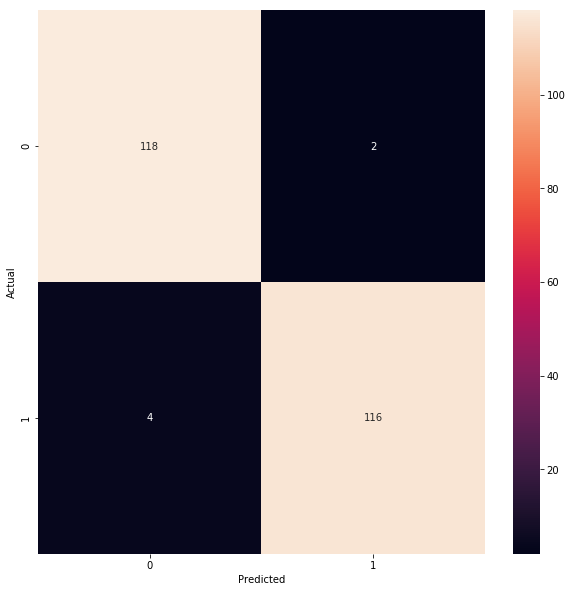

In [22]:
# Fitting a simple Random Forest on TFIDF#########
sqrt_features = int(np.sqrt(xtrain_tfv.shape[1]))
params_rf = {'randomforestclassifier__n_estimators': [sqrt_features,sqrt_features*2,100,200],
                'randomforestclassifier__min_samples_leaf': [0.1,0.2,0.3,0.4,0.5, 1],
                 'randomforestclassifier__max_depth' : [None, 3, 4, 5,],
                #'randomforestclassifier__bootstrap' : [True, False],
                "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3),]}
pipeline_rf = make_pipeline(TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english'), RandomForestClassifier())

accuracies['RandomForest(TF-IDF)'] = grid_search_best_params('RandomForest(TF-IDF)',pipeline_rf, params_rf,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

Log Loss for RandomForest(CV) on Test CountVectorizer : 0.28782979993617486
ROC AUC for RandomForest(CV) on Test CountVectorizer : 0.9989583333333333
Accuracy for RandomForest(CV) on Test CountVectorizer : 0.9916666666666667
Log Loss for RandomForest(CV) on Training CountVectorizer : 0.07995161165250739
ROC AUC for RandomForest(CV) on Training CountVectorizer : 0.9998915466392317
Accuracy for RandomForest(CV) on Training CountVectorizer : 0.9976851851851852
Best Score : 77.17
Best Paramerter Settings :  {'countvectorizer__ngram_range': (1, 1), 'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200}


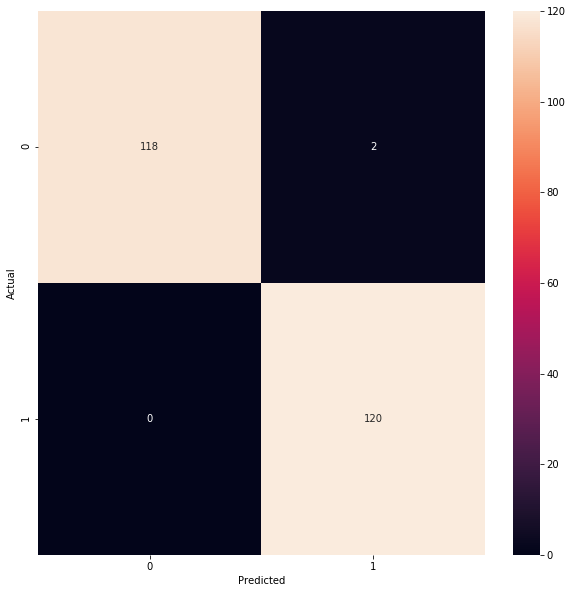

In [23]:
# Fitting a simple Random Forest on TFIDF#########
sqrt_features = int(np.sqrt(xtrain_tfv.shape[1]))
params_rf = {'randomforestclassifier__n_estimators': [sqrt_features,sqrt_features*2,100,200],
                'randomforestclassifier__min_samples_leaf': [0.1,0.2,0.3,0.4,0.5, 1],
                'randomforestclassifier__max_depth' : [None, 3, 4, 5,],
                #'randomforestclassifier__bootstrap' : [True, False],
                "countvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3),]}
pipeline_rf = make_pipeline(CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            stop_words = 'english'), RandomForestClassifier())

accuracies['RandomForest(CV)'] = grid_search_best_params('RandomForest(CV)',pipeline_rf, params_rf,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

Log Loss for ExtremeGradientBoosting(TF-IDF) on Test TF-IDF Vectorizer : 5.180833117516398
ROC AUC for ExtremeGradientBoosting(TF-IDF) on Test TF-IDF Vectorizer : 0.9302430555555556
Accuracy for ExtremeGradientBoosting(TF-IDF) on Test TF-IDF Vectorizer : 0.85
Log Loss for ExtremeGradientBoosting(TF-IDF) on Training TF-IDF Vectorizer : 5.6605416768794505
ROC AUC for ExtremeGradientBoosting(TF-IDF) on Training TF-IDF Vectorizer : 0.9266735253772292
Accuracy for ExtremeGradientBoosting(TF-IDF) on Training TF-IDF Vectorizer : 0.8361111111111111
Best Score : 75.67
Best Paramerter Settings :  {'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 68}


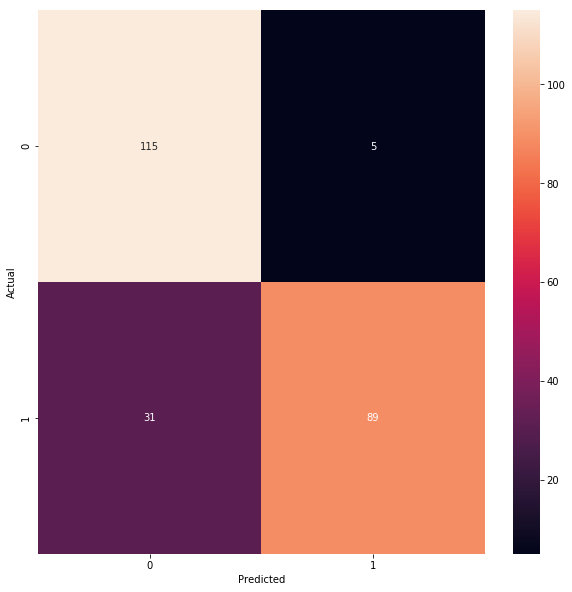

In [24]:
# Fitting a simple XGBoost on TFIDF#########
sqrt_features = int(np.sqrt(xtrain_tfv.shape[1]))
params_xgb = {'xgbclassifier__n_estimators': [sqrt_features,sqrt_features*2, 100, 200 ],
                'xgbclassifier__learning_rate': [0.01,0.1,0.3],
                'xgbclassifier__max_depth' : [2, 3, 4, 5,],
                "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3),]}
pipeline_xgb = make_pipeline(TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english'), xgb.XGBClassifier())

accuracies['ExtremeGradientBoosting(TF-IDF)'] = grid_search_best_params('ExtremeGradientBoosting(TF-IDF)',pipeline_xgb, params_xgb,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

Log Loss for ExtremeGradientBoosting(CV) on Test CountVectorizer : 6.188227422325129
ROC AUC for ExtremeGradientBoosting(CV) on Test CountVectorizer : 0.9147569444444444
Accuracy for ExtremeGradientBoosting(CV) on Test CountVectorizer : 0.8208333333333333
Log Loss for ExtremeGradientBoosting(CV) on Training CountVectorizer : 5.836439146465317
ROC AUC for ExtremeGradientBoosting(CV) on Training CountVectorizer : 0.9233757716049383
Accuracy for ExtremeGradientBoosting(CV) on Training CountVectorizer : 0.8310185185185185
Best Score : 76.88
Best Paramerter Settings :  {'countvectorizer__ngram_range': (1, 2), 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}


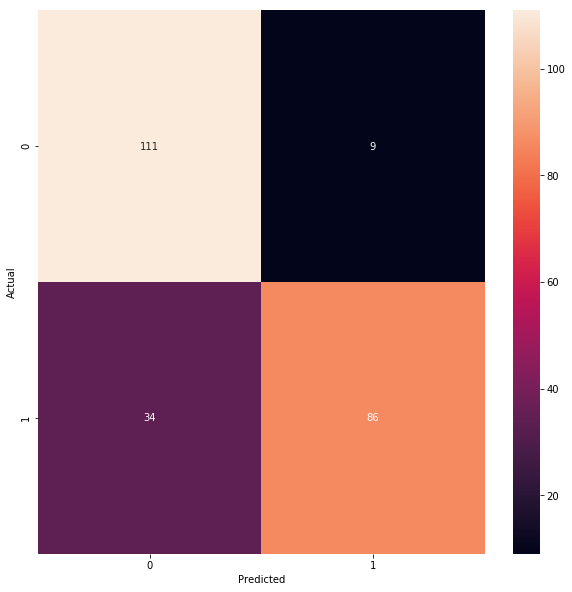

In [25]:
# Fitting a simple XGBoost on TFIDF#########
sqrt_features = int(np.sqrt(xtrain_tfv.shape[1]))
params_xgb = {'xgbclassifier__n_estimators': [sqrt_features,sqrt_features*2, 100, 200 ],
                'xgbclassifier__learning_rate': [0.01,0.1,0.3],
                'xgbclassifier__max_depth' : [2, 3, 4, 5,],
                "countvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2), (1, 3),]}
pipeline_xgb = make_pipeline(CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            stop_words = 'english'), xgb.XGBClassifier())

accuracies['ExtremeGradientBoosting(CV)'] = grid_search_best_params('ExtremeGradientBoosting(CV)',pipeline_xgb, params_xgb,xtrain1,ytrain1,xvalid,yvalid,x_train,y_train)

In [26]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
df = pd.DataFrame(accuracies)
df = df.transpose()
df = df.reset_index()
df = df.rename(columns={'index':'model_name'})
df

,model_name,Best Accuracy,Best Param Settings,Test Accuracy,Test Log Loss,Test ROC AUC,Train Accuracy,Train Log Loss,Train ROC AUC
0,LogisticRegresion(TF-IDF),0.77625,"{'logisticregression__C': 1, 'logisticregressi...",0.9,3.45391,0.95441,0.89537,3.61381,0.952393
1,LogisticRegresion(CV),0.79125,"{'countvectorizer__ngram_range': (1, 1), 'logi...",0.9625,1.29522,0.989722,0.961574,1.3272,0.98915
2,NaiveBayes(TF-IDF),0.765833,"{'multinomialnb__alpha': 1.0, 'tfidfvectorizer...",0.895833,3.59783,0.964965,0.892593,3.70976,0.958293
3,NaiveBayes(CV),0.797083,"{'countvectorizer__ngram_range': (1, 3), 'mult...",0.970833,1.00739,0.997014,0.98287,0.591643,0.998564
4,RandomForest(TF-IDF),0.763333,"{'randomforestclassifier__max_depth': None, 'r...",0.975,0.863476,0.99816,0.988426,0.399757,0.999393
5,RandomForest(CV),0.771667,"{'countvectorizer__ngram_range': (1, 1), 'rand...",0.991667,0.28783,0.998958,0.997685,0.0799516,0.999892
6,ExtremeGradientBoosting(TF-IDF),0.756667,"{'tfidfvectorizer__ngram_range': (1, 1), 'xgbc...",0.85,5.18083,0.930243,0.836111,5.66054,0.926674
7,ExtremeGradientBoosting(CV),0.76875,"{'countvectorizer__ngram_range': (1, 2), 'xgbc...",0.820833,6.18823,0.914757,0.831019,5.83644,0.923376


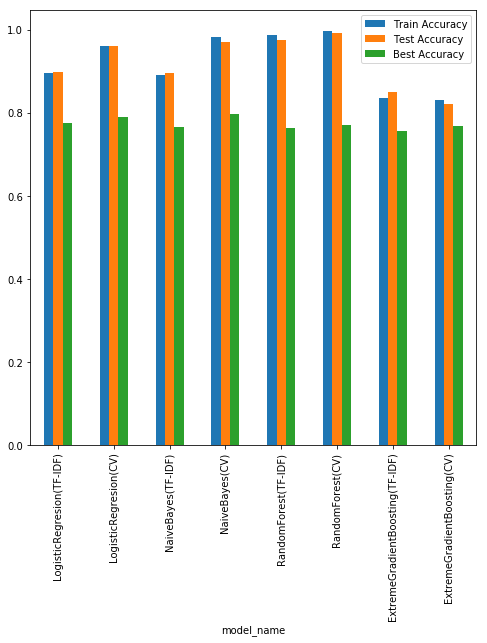

In [27]:
df.plot(x='model_name',y=['Train Accuracy', 'Test Accuracy','Best Accuracy'], kind='bar', figsize=(8,8))

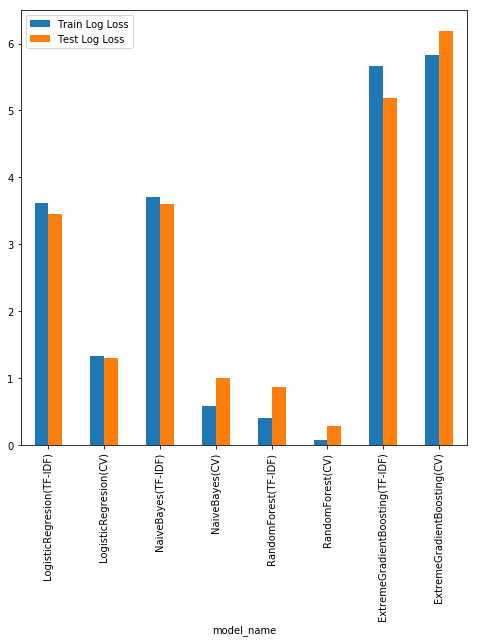

In [28]:
df.plot(x='model_name',y=['Train Log Loss', 'Test Log Loss'], kind='bar', figsize=(8,8))

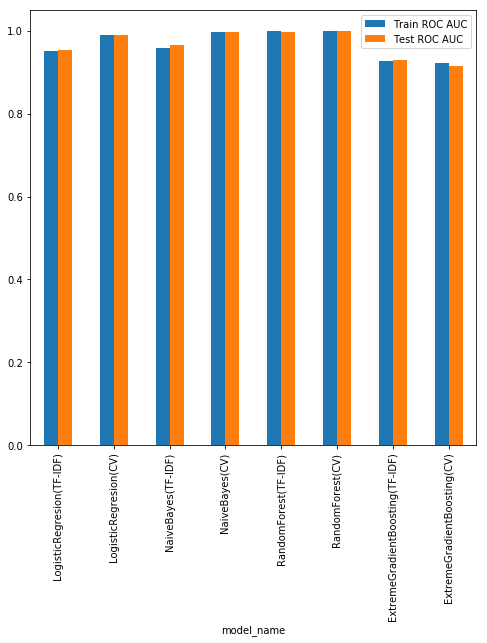

In [29]:
df.plot(x='model_name',y=['Train ROC AUC', 'Test ROC AUC'], kind='bar', figsize=(8,8))

In [30]:
for model_name, grid in grids.items():
    print(model_name)
    print(grid.best_params_)

LogisticRegresion(TF-IDF)
{'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 1)}
LogisticRegresion(CV)
{'countvectorizer__ngram_range': (1, 1), 'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}
NaiveBayes(TF-IDF)
{'multinomialnb__alpha': 1.0, 'tfidfvectorizer__ngram_range': (1, 2)}
NaiveBayes(CV)
{'countvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 1.0}
RandomForest(TF-IDF)
{'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200, 'tfidfvectorizer__ngram_range': (1, 2)}
RandomForest(CV)
{'countvectorizer__ngram_range': (1, 1), 'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 200}
ExtremeGradientBoosting(TF-IDF)
{'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 68}


In [31]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(50), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 51), feature_names[interesting_coefficients], rotation=60, ha="right");

Text(0.5, 1.0, 'Logistic Regression with Count Vectorizer')

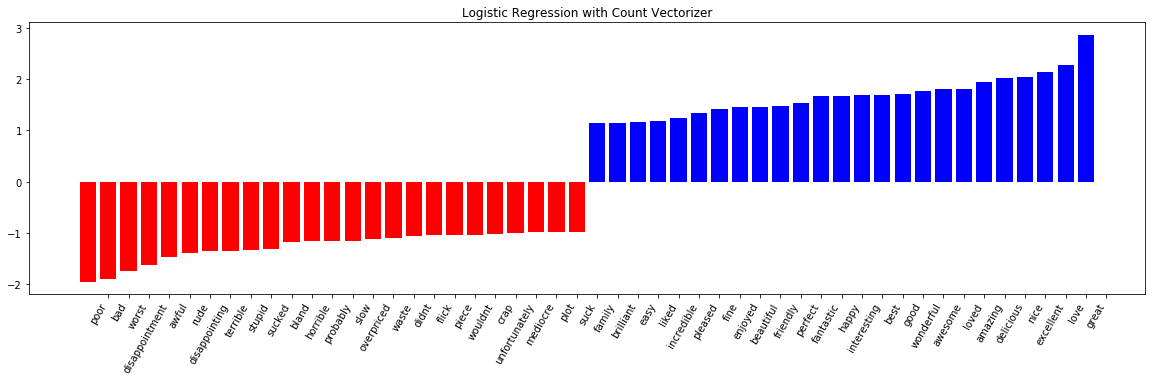

In [32]:
######Count vector Creation##############
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 1), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain1) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain1) 
xvalid_ctv = ctv.transform(xvalid)
lr = LogisticRegression(C=1, penalty='l2')
lr.fit(xtrain_ctv,ytrain1)

visualize_coefficients(lr, ctv.get_feature_names())
plt.title('Logistic Regression with Count Vectorizer')

Text(0.5, 1.0, 'Logistic Regression with TF-IDF Vectorizer')

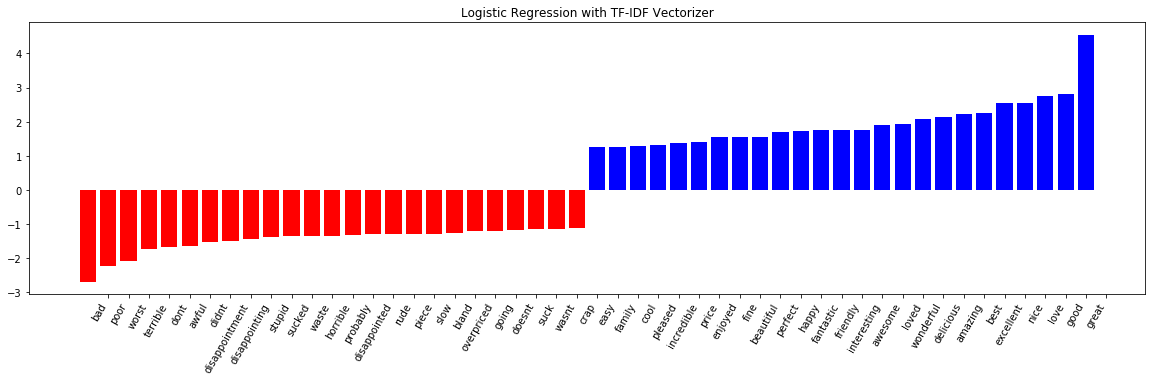

In [33]:
#{'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': None, 
# 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 68, 'tfidfvectorizer__ngram_range': (1, 3)}
######tfidf vector Creation##############
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain1) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain1) 
xvalid_tfv = tfv.transform(xvalid)
lr = LogisticRegression(C=1, penalty='l2')
lr.fit(xtrain_tfv,ytrain1)

visualize_coefficients(lr, tfv.get_feature_names())
plt.title('Logistic Regression with TF-IDF Vectorizer')

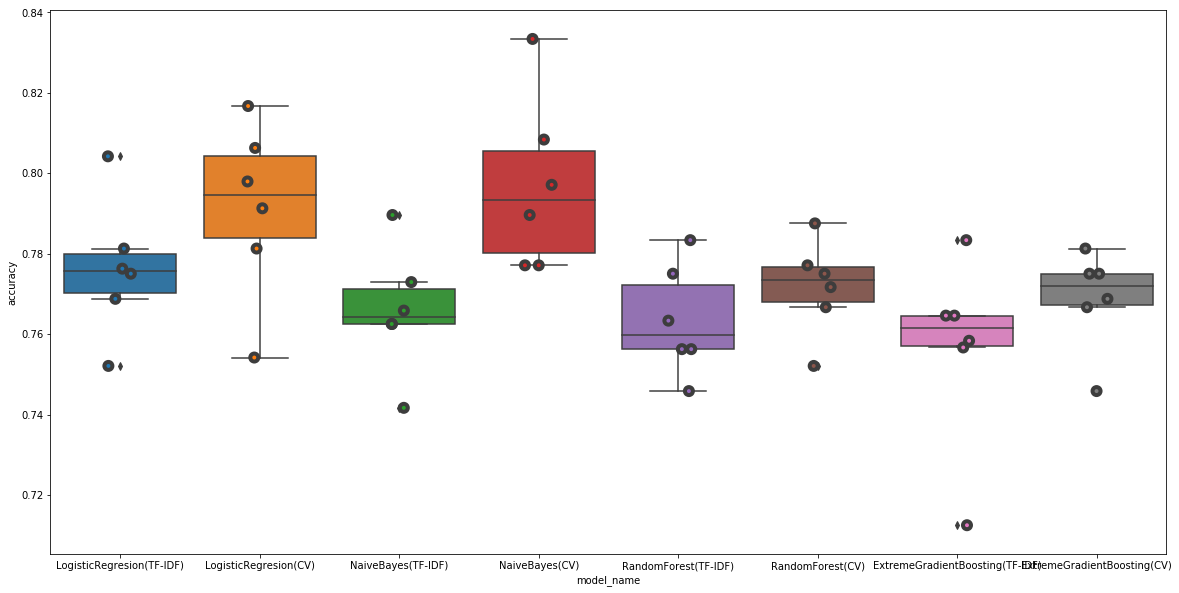

In [34]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(20,10))
CV=5
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    accuracies = df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    accuracies = df_lr[['split0_test_accuracy','split1_test_accuracy','split2_test_accuracy','split3_test_accuracy','split4_test_accuracy','mean_test_accuracy']].values[0]
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

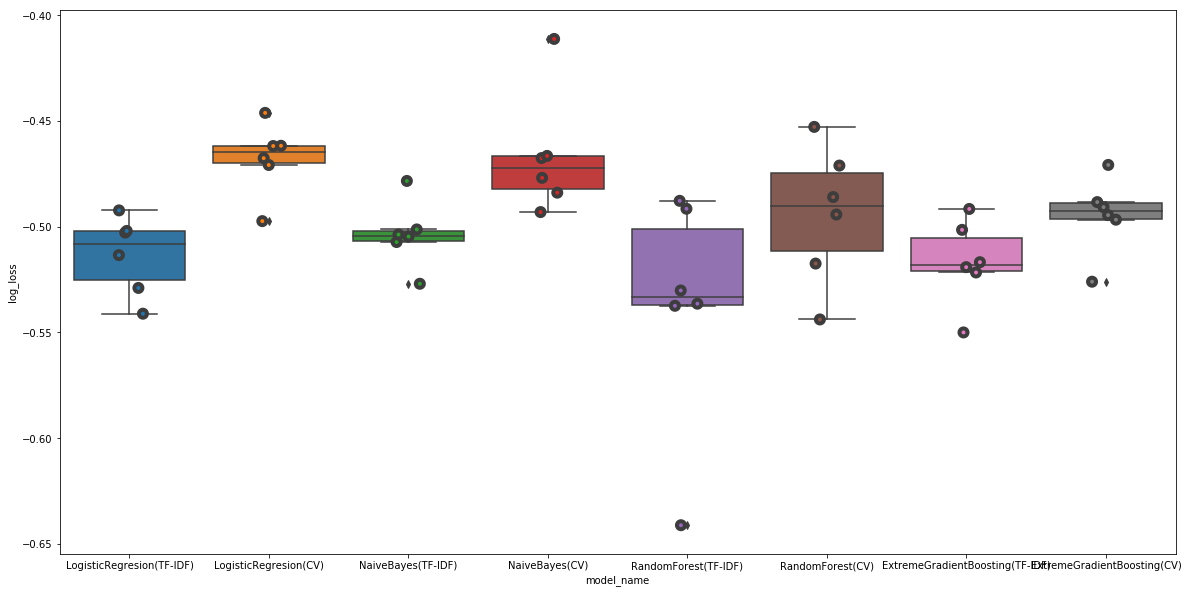

In [35]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(20,10))
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    losses = df_lr[['split0_test_neg_log_loss','split1_test_neg_log_loss','split2_test_neg_log_loss','split3_test_neg_log_loss','split4_test_neg_log_loss','mean_test_neg_log_loss']].values[0]
    for fold_idx, loss in enumerate(losses):
        entries.append((model_name, fold_idx, loss))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'log_loss'])

sns.boxplot(x='model_name', y='log_loss', data=cv_df)
sns.stripplot(x='model_name', y='log_loss', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

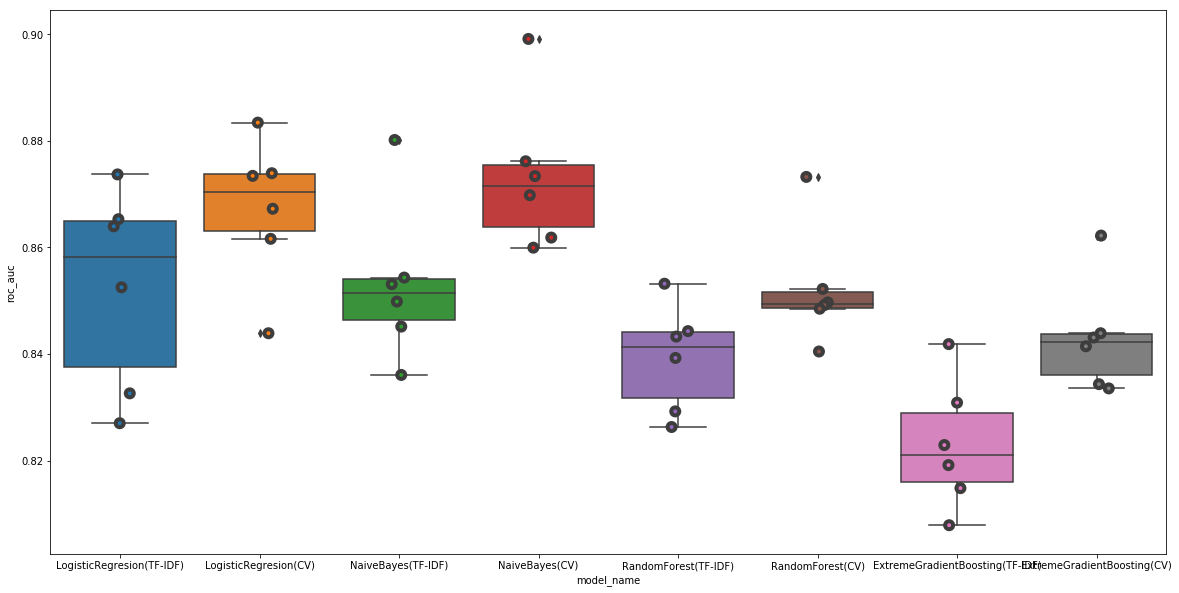

In [36]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(20,10))
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    roc_aucs = df_lr[['split0_test_roc_auc','split1_test_roc_auc','split2_test_roc_auc','split3_test_roc_auc','split4_test_roc_auc','mean_test_roc_auc']].values[0]
    for fold_idx, roc_auc in enumerate(roc_aucs):
        entries.append((model_name, fold_idx, roc_auc))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'roc_auc'])

sns.boxplot(x='model_name', y='roc_auc', data=cv_df)
sns.stripplot(x='model_name', y='roc_auc', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

In [37]:
df

,model_name,Best Accuracy,Best Param Settings,Test Accuracy,Test Log Loss,Test ROC AUC,Train Accuracy,Train Log Loss,Train ROC AUC
0,LogisticRegresion(TF-IDF),0.77625,"{'logisticregression__C': 1, 'logisticregressi...",0.9,3.45391,0.95441,0.89537,3.61381,0.952393
1,LogisticRegresion(CV),0.79125,"{'countvectorizer__ngram_range': (1, 1), 'logi...",0.9625,1.29522,0.989722,0.961574,1.3272,0.98915
2,NaiveBayes(TF-IDF),0.765833,"{'multinomialnb__alpha': 1.0, 'tfidfvectorizer...",0.895833,3.59783,0.964965,0.892593,3.70976,0.958293
3,NaiveBayes(CV),0.797083,"{'countvectorizer__ngram_range': (1, 3), 'mult...",0.970833,1.00739,0.997014,0.98287,0.591643,0.998564
4,RandomForest(TF-IDF),0.763333,"{'randomforestclassifier__max_depth': None, 'r...",0.975,0.863476,0.99816,0.988426,0.399757,0.999393
5,RandomForest(CV),0.771667,"{'countvectorizer__ngram_range': (1, 1), 'rand...",0.991667,0.28783,0.998958,0.997685,0.0799516,0.999892
6,ExtremeGradientBoosting(TF-IDF),0.756667,"{'tfidfvectorizer__ngram_range': (1, 1), 'xgbc...",0.85,5.18083,0.930243,0.836111,5.66054,0.926674
7,ExtremeGradientBoosting(CV),0.76875,"{'countvectorizer__ngram_range': (1, 2), 'xgbc...",0.820833,6.18823,0.914757,0.831019,5.83644,0.923376


In [38]:
for model_name, model in grids.items():
    print(model_name + ' 5 Fold Log Loss(Error)')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    errors = df_lr[['split0_test_neg_log_loss','split1_test_neg_log_loss','split2_test_neg_log_loss','split3_test_neg_log_loss','split4_test_neg_log_loss','mean_test_neg_log_loss']].values[0]
    print(errors)

LogisticRegresion(TF-IDF) 5 Fold Log Loss(Error)
[-0.50278628 -0.50199941 -0.54114772 -0.52896668 -0.49227627 -0.51343527]
LogisticRegresion(CV) 5 Fold Log Loss(Error)
[-0.46171449 -0.46182843 -0.49735553 -0.47080746 -0.44615195 -0.46757157]
NaiveBayes(TF-IDF) 5 Fold Log Loss(Error)
[-0.50465103 -0.50128904 -0.52698995 -0.50724519 -0.47835169 -0.50370538]
NaiveBayes(CV) 5 Fold Log Loss(Error)
[-0.48389085 -0.47689802 -0.49307603 -0.46752669 -0.41117786 -0.46651389]
RandomForest(TF-IDF) 5 Fold Log Loss(Error)
[-0.48776274 -0.49150497 -0.530168   -0.64120021 -0.53641082 -0.53740935]
RandomForest(CV) 5 Fold Log Loss(Error)
[-0.54386637 -0.48597455 -0.51743817 -0.47107755 -0.45278059 -0.49422745]
ExtremeGradientBoosting(TF-IDF) 5 Fold Log Loss(Error)
[-0.50149396 -0.52165083 -0.55000589 -0.51912884 -0.49160049 -0.516776  ]
ExtremeGradientBoosting(CV) 5 Fold Log Loss(Error)
[-0.48835927 -0.49074196 -0.52601324 -0.49667328 -0.47077415 -0.49451238]


In [39]:
for model_name, model in grids.items():
    print(model_name + '5 Fold ROC AUC')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    roc_aucs = df_lr[['split0_test_roc_auc','split1_test_roc_auc','split2_test_roc_auc','split3_test_roc_auc','split4_test_roc_auc','mean_test_roc_auc']].values[0]
    print(roc_aucs)

LogisticRegresion(TF-IDF)5 Fold ROC AUC
[0.86530382 0.86397569 0.82700521 0.83261285 0.87371528 0.85252257]
LogisticRegresion(CV)5 Fold ROC AUC
[0.87344618 0.87394097 0.84389757 0.86162326 0.8834375  0.8672691 ]
NaiveBayes(TF-IDF)5 Fold ROC AUC
[0.85434896 0.84984375 0.83606771 0.84514757 0.88018229 0.85311806]
NaiveBayes(CV)5 Fold ROC AUC
[0.85996528 0.86981771 0.86185764 0.87618056 0.89914931 0.8733941 ]
RandomForest(TF-IDF)5 Fold ROC AUC
[0.84327257 0.84429687 0.8262934  0.82922743 0.85319444 0.83925694]
RandomForest(CV)5 Fold ROC AUC
[0.84967882 0.84917535 0.84046875 0.84849826 0.87324653 0.85221354]
ExtremeGradientBoosting(TF-IDF)5 Fold ROC AUC
[0.83086806 0.81914062 0.8078559  0.81481771 0.84185764 0.82290799]
ExtremeGradientBoosting(CV)5 Fold ROC AUC
[0.84144965 0.84389757 0.83434028 0.83354167 0.8622309  0.84309201]


In [40]:
for model_name, model in grids.items():
    print(model_name+' 5 Fold Accuracies')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    accuracies = df_lr[['split0_test_accuracy','split1_test_accuracy','split2_test_accuracy','split3_test_accuracy','split4_test_accuracy','mean_test_accuracy']].values[0]
    print(accuracies)

LogisticRegresion(TF-IDF) 5 Fold Accuracies
[0.78125    0.775      0.75208333 0.76875    0.80416667 0.77625   ]
LogisticRegresion(CV) 5 Fold Accuracies
[0.79791667 0.80625    0.75416667 0.78125    0.81666667 0.79125   ]
NaiveBayes(TF-IDF) 5 Fold Accuracies
[0.77291667 0.7625     0.7625     0.74166667 0.78958333 0.76583333]
NaiveBayes(CV) 5 Fold Accuracies
[0.77708333 0.78958333 0.77708333 0.80833333 0.83333333 0.79708333]
RandomForest(TF-IDF) 5 Fold Accuracies
[0.74583333 0.775      0.75625    0.75625    0.78333333 0.76333333]
RandomForest(CV) 5 Fold Accuracies
[0.775      0.7875     0.76666667 0.75208333 0.77708333 0.77166667]
ExtremeGradientBoosting(TF-IDF) 5 Fold Accuracies
[0.76458333 0.76458333 0.7125     0.75833333 0.78333333 0.75666667]
ExtremeGradientBoosting(CV) 5 Fold Accuracies
[0.78125    0.775      0.74583333 0.76666667 0.775      0.76875   ]


In [41]:
grids.keys()

dict_keys(['LogisticRegresion(TF-IDF)', 'LogisticRegresion(CV)', 'NaiveBayes(TF-IDF)', 'NaiveBayes(CV)', 'RandomForest(TF-IDF)', 'RandomForest(CV)', 'ExtremeGradientBoosting(TF-IDF)', 'ExtremeGradientBoosting(CV)'])

In [42]:
for model_name, grid in grids.items():
    submission_predictions = grid.predict_proba(x_test)[:,1]
    model_name = model_name.replace('(','_').replace(')','').replace('-','_')
    np.savetxt("yproba_part1_%s.txt"%model_name, submission_predictions,newline='\r\n')
    #print(display.HTML('<a href="yproba_part1_%s.txt" target="_blank">Y_TEST_PROBA_PART1_%s</a>'%(model_name,model_name)))

In [43]:
%ls

__notebook__.ipynb
__output__.json
yproba_part1_ExtremeGradientBoosting_CV.txt
yproba_part1_ExtremeGradientBoosting_TF_IDF.txt
yproba_part1_LogisticRegresion_CV.txt
yproba_part1_LogisticRegresion_TF_IDF.txt
yproba_part1_NaiveBayes_CV.txt
yproba_part1_NaiveBayes_TF_IDF.txt
yproba_part1_RandomForest_CV.txt
yproba_part1_RandomForest_TF_IDF.txt
